**Contents/Plan**
- load data
- train/test/validation splits?
- establish simple models
  - RidgeCV, RandomForest
- Evaluate Features, compare different answers:
  - model based feature importance
    - regression, decision trees
  - univariate feature selection
    - SelectKBest with `f_regression`, `mutual_info_regression`
  - sequential feature selection
    - same basic models as above

- for later
  - permutation feature importance with nominated model(s)

In [104]:

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.feature_selection import SelectKBest, f_regression,  mutual_info_regression# other ways to automatically feature select?
from sklearn.linear_model import LinearRegression, Ridge,  RidgeCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

from sklearn.pipeline import make_pipeline

### Load/Split
- *should home/away_o/d_scores be dropped!?!?!*

In [145]:
data = pd.read_parquet('data/game_stats_0.parquet', engine='pyarrow')

# let y be "home_win" for classification problems
X = data.drop(
        columns = ['game','date','week','home','away','home_score','away_score', 'home_margin','home_win']
)
y = data['home_margin']

In [106]:
data.columns[data.columns.str.endswith('scores')]

Index(['away_o_scores', 'away_d_scores', 'home_o_scores', 'home_d_scores'], dtype='object')

In [146]:
X.drop(columns=data.columns[data.columns.str.endswith('scores')], inplace=True)

In [113]:
# X = X[['away_throws','away_turnovers','away_completions','away_blocks',
#    'home_throws','home_turnovers','home_completions','home_blocks']]

In [147]:
features = X.columns
print(features)

Index(['away_completions', 'away_throws', 'away_blocks', 'away_turnovers',
       'away_o_points', 'away_o_possessions', 'away_d_points',
       'away_d_possessions', 'home_completions', 'home_throws', 'home_blocks',
       'home_turnovers', 'home_o_points', 'home_o_possessions',
       'home_d_points', 'home_d_possessions', 'home_completion_rate',
       'away_completion_rate', 'home_block_rate', 'away_block_rate',
       'away_throw_per_score', 'home_throw_per_score', 'home_hold_rate',
       'away_hold_rate', 'home_o_poss_per_hold', 'away_o_poss_per_hold',
       'home_break_rate', 'away_break_rate', 'home_d_poss_per_pt',
       'away_d_poss_per_pt', 'home_break_per_poss', 'away_break_per_poss'],
      dtype='object')


In [148]:
X, X_validate, y, y_validate = train_test_split(X, y, test_size=0.1)

In [149]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_validate = scaler.transform(X_validate)

In [150]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [151]:
X_train.shape, X_test.shape, X_validate.shape

((963, 32), (322, 32), (143, 32))

### Testing with only throws,completions,turnovers,blocks

In [125]:
ridge = Ridge(alpha=0.1).fit(X_train, y_train)

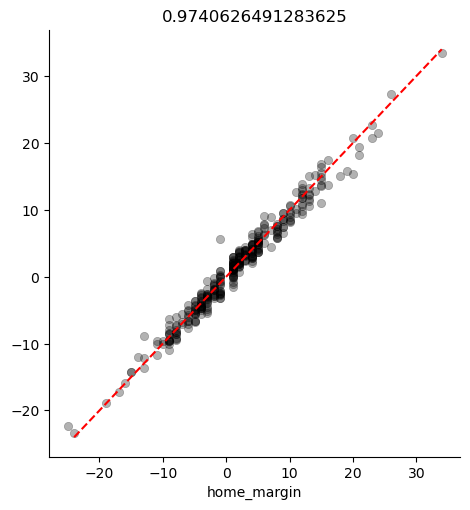

In [137]:
sns.relplot(x=y_test, y=ridge.predict(X_test), 
            edgecolor='face',alpha=0.3, color='k')
plt.title(ridge.score(X_test,y_test))
plt.plot([-24,34],[-24,34],'r--')
plt.show()

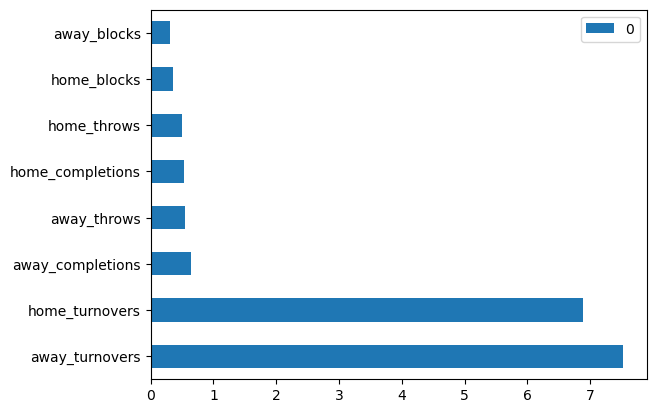

In [138]:
pd.DataFrame(np.abs(ridge.coef_), index=features).sort_values(0, ascending=False).head(10).plot.barh()
plt.show()

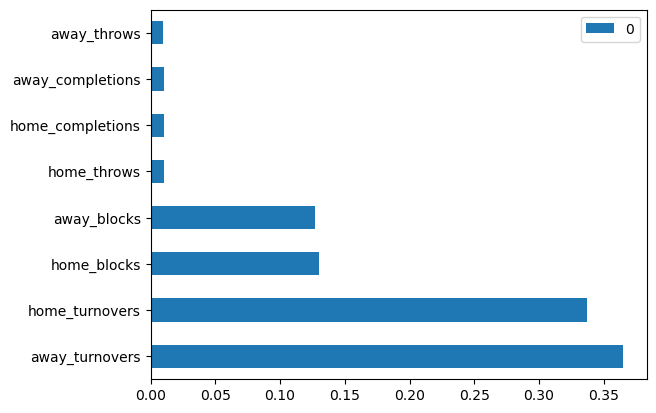

In [139]:
xtree_est = ExtraTreesRegressor().fit(X_train,y_train)
pd.DataFrame(xtree_est.feature_importances_, index=features).sort_values(0, ascending=False).head(10).plot.barh()
plt.show()

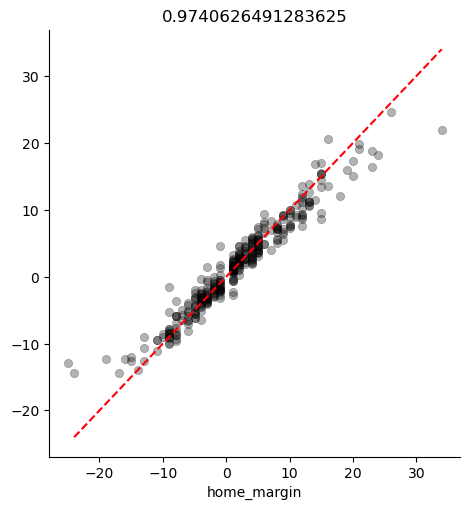

In [142]:
sns.relplot(x=y_test, y=xtree_est.predict(X_test), 
            edgecolor='face',alpha=0.3, color='k')
plt.title(ridge.score(X_test,y_test))
plt.plot([-24,34],[-24,34],'r--')
plt.show()

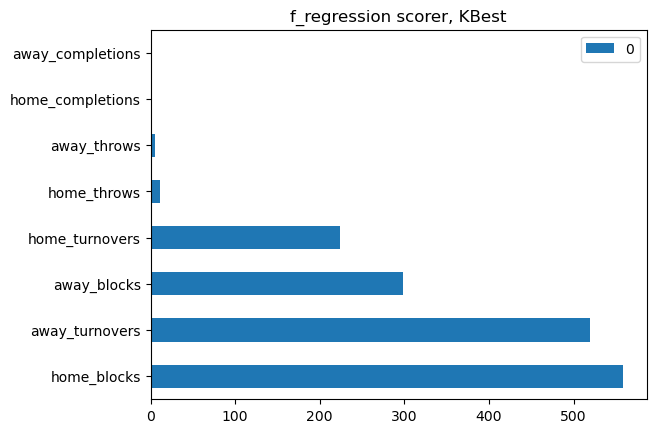

In [143]:
kbest_1 = SelectKBest(score_func=f_regression, k='all')
kbest_1.fit(X,y)
pd.DataFrame(kbest_1.scores_, index=features).sort_values(0, ascending=False).head(10).plot.barh()
plt.title('f_regression scorer, KBest')
plt.show()

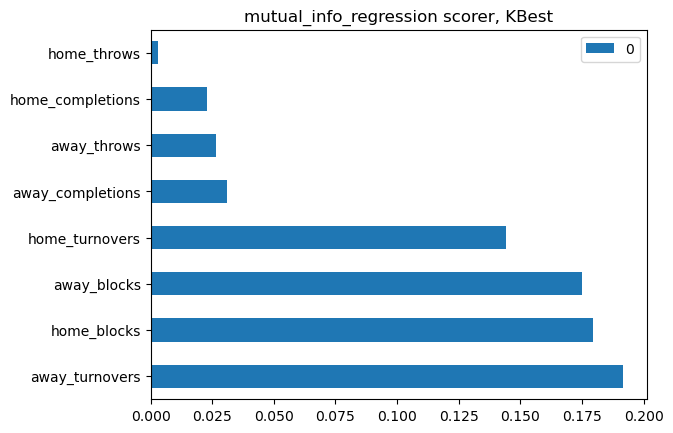

In [144]:
kbest_2 = SelectKBest(score_func=mutual_info_regression, k='all')
kbest_2.fit(X,y)
pd.DataFrame(kbest_2.scores_, index=features).sort_values(0, ascending=False).head(10).plot.barh()
plt.title('mutual_info_regression scorer, KBest')
plt.show()

### RidgeCV

In [160]:
np.logspace(-2, 2, 10)

array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02])

In [164]:
ridge = RidgeCV(alphas=np.logspace(-2, 2, 10)).fit(X_train, y_train)

In [165]:
ridge.alpha_, ridge.intercept_, ridge.best_score_

(1.6681005372000592, 1.497739318807945, -0.251108637060549)

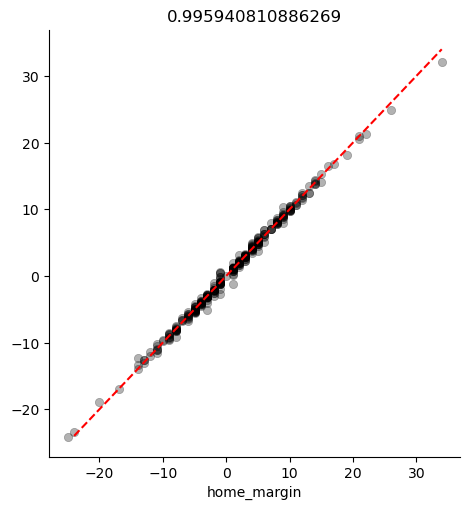

In [166]:
sns.relplot(x=y_test, y=ridge.predict(X_test), 
            edgecolor='face',alpha=0.3, color='k')
plt.title(ridge.score(X_test,y_test))
plt.plot([-24,34],[-24,34],'r--')
plt.show()

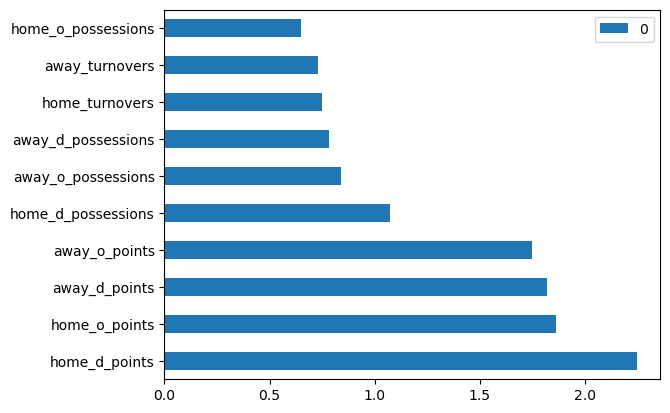

In [154]:
pd.DataFrame(np.abs(ridge.coef_), index=features).sort_values(0, ascending=False).head(10).plot.barh()
plt.show()

### ExtraTrees, RandomForest

In [98]:
xtree_est = ExtraTreesRegressor().fit(X,y)

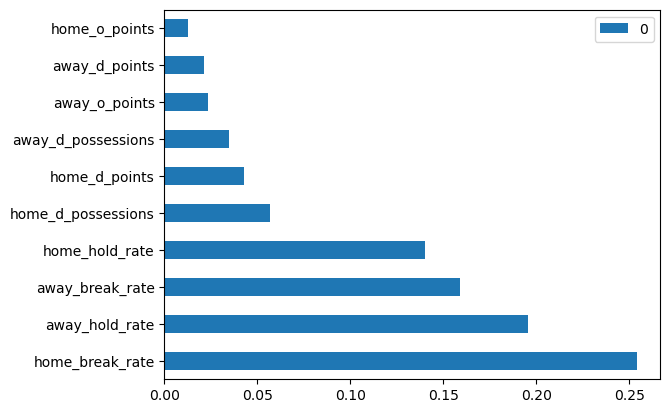

In [99]:
pd.DataFrame(xtree_est.feature_importances_, index=features).sort_values(0, ascending=False).head(10).plot.barh()
plt.show()

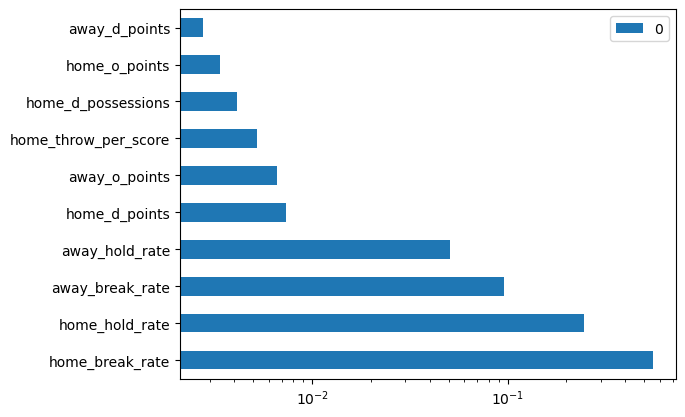

In [100]:
rf_est = RandomForestRegressor().fit(X,y)
pd.DataFrame(rf_est.feature_importances_, index=features).sort_values(0, ascending=False).head(10).plot.barh()
plt.xscale('log')
plt.show()

### SelectKBest

In [101]:
kbest_1 = SelectKBest(score_func=f_regression, k='all')
kbest_1.fit(X,y)

SelectKBest(k='all', score_func=<function f_regression at 0x000001FB8A6E5240>)

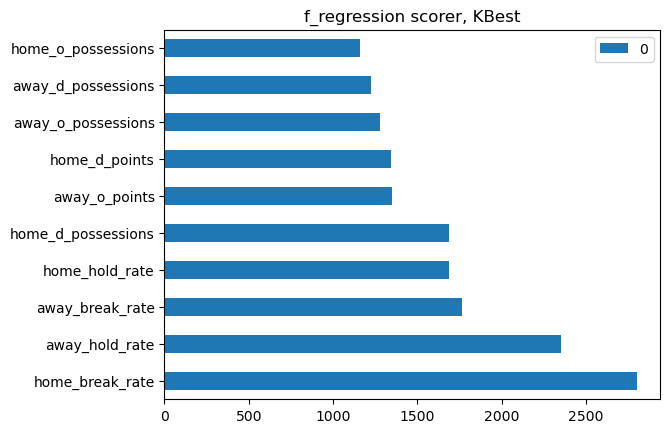

In [102]:
pd.DataFrame(kbest_1.scores_, index=features).sort_values(0, ascending=False).head(10).plot.barh()
plt.title('f_regression scorer, KBest')
plt.show()

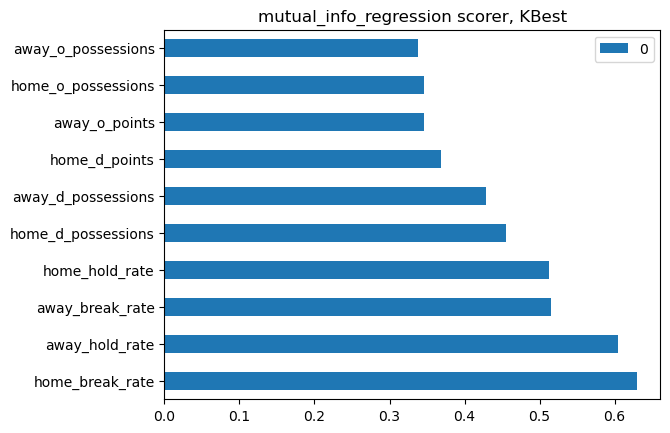

In [103]:
kbest_2 = SelectKBest(score_func=mutual_info_regression, k='all')
kbest_2.fit(X,y)
pd.DataFrame(kbest_2.scores_, index=features).sort_values(0, ascending=False).head(10).plot.barh()
plt.title('mutual_info_regression scorer, KBest')
plt.show()